# Applying SHRED to the Mice Dataset 

Dataset obtained from Allen Barain Atlas https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

Goal: Reconstruct LFP potential of different brain regions from only pupil dilation (one session 756029989 and 180 degree orientation drifting gratings)

LFP band: 
- ~2.5 kHz original sample rate
- 1000 Hz analog lo-pass
- 625 Hz digital lo-pass
- NWB includes every 2nd sample and every 4th channel

In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge

In [2]:
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image

from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

In [3]:
#Set up data cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = "/home/amy/SHRED_neuro/mice/data" #where data will be stored
manifest_path = os.path.join(data_directory, 'manifest.json')
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

sessions.head()


# Can also filter which mice to select
filtered_sessions = sessions[(sessions.index == 756029989)]

filtered_sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."


In [5]:
#Loading dataset for specific session
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])


/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_c

**Importing local field potential (LFP) data**

In [6]:
# list the probes recorded from in this session
session.probes.head()

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
760640083,probeA,See electrode locations,29999.949611,1249.997900,True
760640087,probeB,See electrode locations,29999.902541,1249.995939,True
760640090,probeC,See electrode locations,29999.905275,1249.996053,True
760640094,probeD,See electrode locations,29999.905275,1249.996053,True
760640097,probeE,See electrode locations,29999.985335,1249.999389,True


In [7]:
{session.probes.loc[probe_id].description : 
     list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
     for probe_id in session.probes.index.values}

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


{'probeA': [nan, 'APN', 'DG', 'CA1', 'VISam'],
 'probeB': ['VISpm', nan, 'LP', 'DG', 'CA1', 'PO', 'Eth'],
 'probeC': ['VISp', nan, 'POL', 'APN', 'MB', 'SCig', 'POST', 'SUB'],
 'probeD': ['VISl', nan, 'TH', 'DG', 'CA3', 'CA1'],
 'probeE': [nan, 'VPM', 'TH', 'LGd', 'CA3', 'CA2', 'CA1', 'VISal'],
 'probeF': [nan, 'DG', 'CA1', 'VISrl']}

In [8]:
probe_id = session.probes.index.values[0]
lfp = session.get_lfp(probe_id)

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 beca

In [9]:
print(lfp)

<xarray.DataArray 'LFP' (time: 12453025, channel: 87)>
array([[ 1.18950002e-05,  2.73000005e-05,  9.16499994e-06, ...,
         0.00000000e+00,  2.73000001e-06,  3.89999997e-07],
       [ 9.41850012e-05,  8.95049961e-05,  1.22849997e-05, ...,
         5.84999998e-06,  5.84999998e-06, -1.15049997e-05],
       [ 6.04499983e-05,  5.79150001e-05,  1.48199997e-05, ...,
         0.00000000e+00,  3.90000014e-06, -1.44300002e-05],
       ...,
       [ 1.05299996e-05,  5.12849983e-05,  8.32649966e-05, ...,
         0.00000000e+00, -3.80249985e-05, -2.16449989e-05],
       [-1.36500000e-06,  3.56849996e-05,  5.46000010e-05, ...,
         0.00000000e+00, -2.84700000e-05, -2.43750001e-05],
       [-1.01400001e-05,  1.46249995e-05,  3.56849996e-05, ...,
         2.73000001e-06, -1.26750001e-05, -9.55500036e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 3.774 3.775 3.776 ... 9.966e+03 9.966e+03 9.966e+03
  * channel  (channel) int64 850126378 850126386 ... 850127058 850127066


In [9]:
# now use a utility to associate intervals of /rows with structures
# structure_acronyms, intervals = session.channel_structure_intervals(lfp["channel"])
# interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

# print(structure_acronyms)
# print(intervals)


## For probe C, mismatch between channels in lfp["channel"] and session.channels.index
lfp_channels = lfp["channel"].values.tolist()
valid_channels = [ch for ch in lfp_channels if ch in session.channels.index]
structure_acronyms, intervals = session.channel_structure_intervals(valid_channels)
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

print(structure_acronyms)
print(intervals)
print(interval_midpoints)

['APN' 'DG' 'CA1' 'VISam' nan]
[ 0 27 35 51 74 87]
[13.5, 31.0, 43.0, 62.5, 80.5]


Get Dilation data

In [10]:
gaze_data = session.get_screen_gaze_data()
gaze_data

/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/amy/SHRED_neuro/neuroenv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.20620,0.072246,0.008627,3.192181,0.863288,11.996034,3.294251
3.22948,0.072116,0.008734,3.103325,0.916339,11.669031,3.496204
3.23714,0.072292,0.008807,3.116553,0.919020,11.717276,3.506406
3.27028,0.072347,0.008060,3.107700,1.061316,11.677819,4.047634
3.30396,0.072026,0.008814,3.285226,0.929605,12.331983,3.546691
...,...,...,...,...,...,...
9939.71240,NaN,NaN,NaN,NaN,NaN,NaN
9939.74576,NaN,NaN,NaN,NaN,NaN,NaN
9939.77918,NaN,NaN,NaN,NaN,NaN,NaN


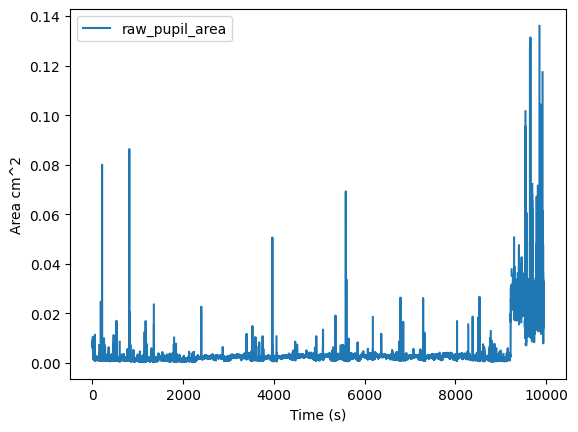

In [11]:
ax = gaze_data[["raw_pupil_area"]].plot()
_ = ax.set_ylabel("Area cm^2")

[0.00862717 0.00873377 0.0088066  ...        nan        nan        nan]
[1585.76101, 1585.79423, 1585.82794, 1585.861, 1585.89441, 1585.92769, 1585.96098, 1585.99811, 1586.02783, 1586.06128, 1586.09457, 1586.12775, 1586.16114, 1586.19435, 1586.22807, 1586.26094, 1586.29443, 1586.33296, 1586.36113, 1586.39459, 1586.42789, 1586.46114, 1586.49455, 1586.52769, 1586.56098, 1586.59437, 1586.6277, 1586.66683, 1586.69454, 1586.72783, 1586.76109, 1586.79447, 1586.82788, 1586.86114, 1586.89449, 1586.9277, 1586.96113, 1586.99864, 1587.02783, 1587.06126, 1587.09465, 1587.12765, 1587.16095, 1587.19441, 1587.2278, 1587.261, 1587.29443, 1587.33217, 1587.36105, 1587.39481, 1587.42781, 1587.46101, 1587.49434, 1587.52769, 1587.56114, 1587.59456, 1587.6277, 1587.66546, 1587.69456, 1587.72797]
60
(1200,)


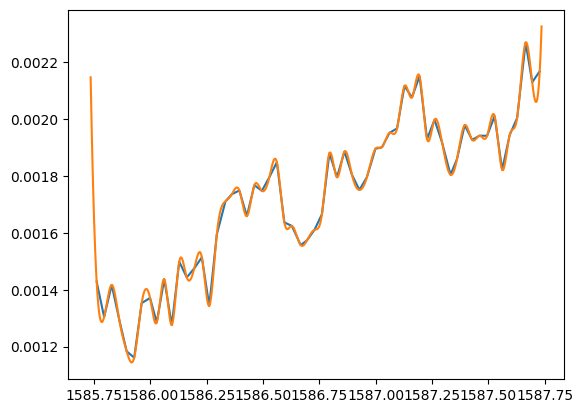

In [18]:
time = gaze_data.index
pupil_area = gaze_data["raw_pupil_area"].values
print(pupil_area)


time_stim = []
pupil_stim = []
for k in range(len(time)):
    if 1585.734418<=time[k]<=1587.736098:
        time_stim.append(time[k])
        pupil_stim.append(pupil_area[k])


print(time_stim)
plt.plot(time_stim, pupil_stim)
print(len(time_stim))


## Spline the data
cs = CubicSpline(time_stim, pupil_stim)
t_spline = np.linspace(1585.734418,1587.736098, len(time_stim)*20 )
pupil_spline = cs(t_spline)

plt.plot(t_spline, pupil_spline)
print(pupil_spline.shape)

Aligning the LFP data to a particular stimulus

In [19]:
stim_table = session.get_stimulus_table('drifting_gratings')
stim_table[stim_table['stimulus_condition_id'] == 246].head(10)

,stimulus_block,start_time,stop_time,orientation,phase,stimulus_name,spatial_frequency,temporal_frequency,contrast,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1585.734418,1587.736098,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00168,246
3800,2.0,1591.739398,1593.741078,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00168,246
3849,2.0,1738.862391,1740.864071,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00168,246
3879,2.0,1828.937691,1830.939371,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00168,246
3882,2.0,1837.945248,1839.946898,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00165,246
3921,2.0,1955.043111,1957.044791,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00168,246
3996,2.0,2180.231388,2182.233048,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00166,246
31006,5.0,3192.077251,3194.078931,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00168,246
31079,5.0,3411.260508,3413.262108,180.0,"[42471.86666667, 42471.86666667]",drifting_gratings,0.04,2.0,0.8,"[250.0, 250.0]",2.00160,246


In [20]:
# presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'drifting_gratings']
presentation_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_condition_id == 246]

presentation_times = presentation_table.start_time.values
presentation_ids = presentation_table.index.values

In [21]:
print(presentation_table)

                         stimulus_block   start_time    stop_time y_position  \
stimulus_presentation_id                                                       
3798                                2.0  1585.734418  1587.736098       null   
3800                                2.0  1591.739398  1593.741078       null   
3849                                2.0  1738.862391  1740.864071       null   
3879                                2.0  1828.937691  1830.939371       null   
3882                                2.0  1837.945248  1839.946898       null   
3921                                2.0  1955.043111  1957.044791       null   
3996                                2.0  2180.231388  2182.233048       null   
31006                               5.0  3192.077251  3194.078931       null   
31079                               5.0  3411.260508  3413.262108       null   
31180                               5.0  3714.513981  3716.515651       null   
49241                               7.0 

In [22]:
dt = 1/600
sr = 1/dt
trial_window = np.arange(0, 2, dt)
time_selection = np.concatenate([trial_window + t for t in presentation_times])

inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                  names=('presentation_id', 'time_from_presentation_onset'))

ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
ds = ds.assign(time=inds).unstack('time')

aligned_lfp = ds['aligned_lfp']



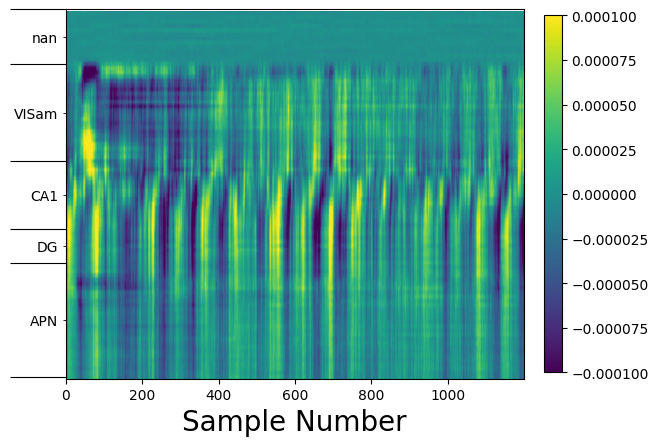

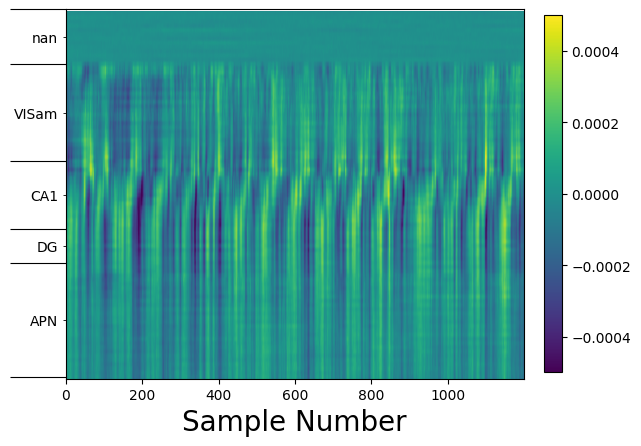

In [23]:
fig, ax = plt.subplots()
im = ax.imshow(aligned_lfp.mean(dim='presentation_id'), aspect='auto', origin='lower', vmin=-1e-4, vmax=1e-4)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1
# time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
# ax.set_xticks(time_label_indices + 0.5)
# ax.set_xticklabels(time_labels)
ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)

plt.show()


## just one
fig, ax = plt.subplots()
im = ax.imshow(aligned_lfp[:,11,:], aspect='auto', origin='lower', vmin=-0.5e-3, vmax=0.5e-3)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1
# time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
# ax.set_xticks(time_label_indices + 0.5)
# ax.set_xticklabels(time_labels)
ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)

plt.show()



(74, 1200)


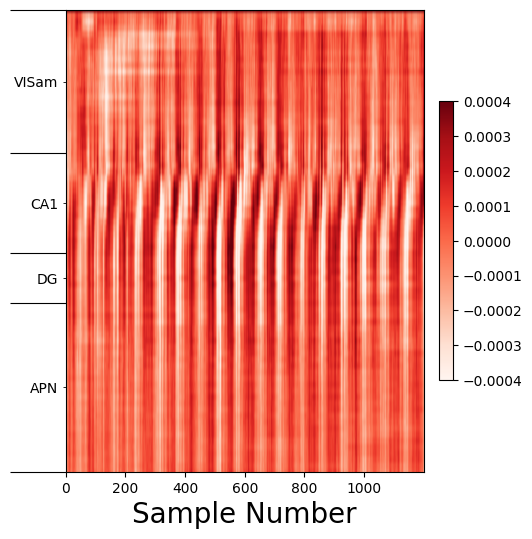

In [24]:
### save data as np arrays
sens_max = 74
probe = 'a'

lfp_np = aligned_lfp.data
data = np.vstack((lfp_np[:sens_max,0,:], pupil_spline))
print(lfp_np[:sens_max,0,:].shape)

n_t = data.shape[1]
n_s = data.shape[0]


## Plot the numpy array
fig, ax = plt.subplots(figsize = (5,6))
im = ax.imshow(data, aspect='auto', origin='lower', vmin=-0.4e-3, vmax=0.4e-3, cmap = 'Reds')

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)
# for y in [0,1000, 2000]:
#     plt.axvline(y, color='white', linestyle='--', linewidth = '1.25')
# ax.set_xlim((-15,data.shape[1]))
ax.set_ylim((0,sens_max))

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Sample Number", fontsize=20)
plt.colorbar(im, fraction=0.036, pad=0.04)
plt.show()



**Applying SHRED on Dataset**

In [25]:
#Importing packages

os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.chdir("../") 
os.chdir("/home/amy/SHRED_neuro/shred")
from processdata_shred import load_data as load_data_shred
from processdata_shred import TimeSeriesDataset as TimeSeriesDataset_shred
import models_shred


# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [26]:
load_X = data.T

latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred
num_neurons = 1 
lags = 50
test_val_size = 300

train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[int(test_val_size/2):test_val_size]
test_indices = valid_test_indices[:int(test_val_size/2)]


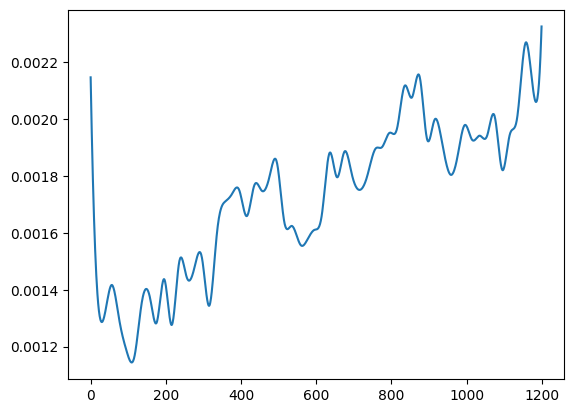

In [27]:
plt.plot(load_X[:, -1])

In [29]:
# Randomly select the sensors from the CA1 region
print(intervals)
print(structure_acronyms)

for k in range(3,4):
    neuron_locations = [-1]
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_3/neuron_loc_{probe}_{k}.npy"
    print(file_path)
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)


    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_3/train_recons_{probe}_{k}.npy"
    np.save(file_path, train_recons)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_3/test_recons_{probe}_{k}.npy"
    np.save(file_path, test_recons)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_3/train_gt_{probe}_{k}.npy"
    np.save(file_path, train_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_3/test_gt_{probe}_{k}.npy"
    np.save(file_path, test_ground_truth)
    file_path = f"/home/amy/SHRED_neuro/mice/data_output/exp_3/mse_{probe}_{k}.npy"
    np.save(file_path, [mse_train, mse_test])

[0, 27, 35, 51, 74, 87]
['APN', 'DG', 'CA1', 'VISam', 'nan']
/home/amy/SHRED_neuro/mice/data_output/exp_3/neuron_loc_a_3.npy
1 : tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0360, device='cu

Plotting the data

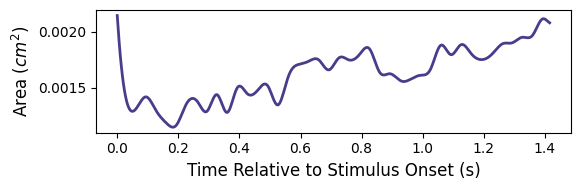

In [31]:
## Plotting the Pupil Area
time = np.linspace(0,2, 600)
plt.figure(figsize = (6, 2))
plt.plot(time[:425], pupil_spline[:425], color = "darkslateblue", linewidth = 2)
plt.xlabel("Time Relative to Stimulus Onset (s)", fontsize = 12)
plt.ylabel("Area ($cm^2$)", fontsize = 12)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/pupil.png", transparent = True, dpi = 400)


(850, 75)
(1000, 75)


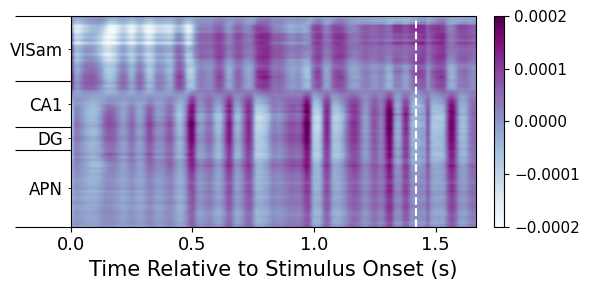

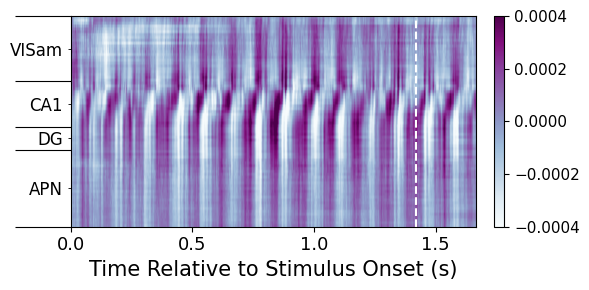

In [37]:
## Probe A
structure_acronyms = ['APN', 'DG', 'CA1', 'VISam', 'nan']
intervals = [0, 27, 35, 51, 74 ,87]
interval_midpoints = [13.5, 31.0, 43.0, 62.5, 80.5]

### Load the data 
sens_max = 74
probe = 'a'
time = np.linspace(0, 1.5, 4)
time_window = np.linspace(0,1.666667, 1000)
data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/train_recons_a_3.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/test_recons_a_3.npy")
data_recon = np.vstack((data_train, data_test))

data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/train_gt_a_3.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/test_gt_a_3.npy")
data_gt= np.vstack((data_train, data_test))

neuron_loc = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/neuron_loc_a_3.npy")
print(data_train.shape)
print(data_recon.shape)

## Plot the Reconstruction
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_recon.T, aspect='auto', origin='lower', extent=[0, 1.666667, 0, 75], vmin=-0.2e-3, vmax=0.2e-3, cmap = 'BuPu')
ax.set_xticks(time)
ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)
plt.axvline(time_window[850], color='white', linestyle='--', linewidth = '1.5')
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
plt.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylim((0,sens_max))

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Time Relative to Stimulus Onset (s)", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/pupil_recon.png", transparent = True, dpi = 400)
plt.show()

## Plot the Ground Truth
fig, ax = plt.subplots(figsize = (6,3))
im = ax.imshow(data_gt.T, aspect='auto', origin='lower', extent=[0, 1.666667, 0, 75], vmin=-0.4e-3, vmax=0.4e-3, cmap = 'BuPu')
ax.set_xticks(time)
ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints,  minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)
plt.axvline(time_window[850], color='white', linestyle='--', linewidth = '1.5')
ax.set_ylim((0,sens_max))
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(12) 
plt.tick_params(axis='both', which='major', labelsize=13)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(trial_window), num_time_labels)).astype(int) - 1

ax.set_xlabel("Time Relative to Stimulus Onset (s)", fontsize=15)
cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/mice/data_output/figs/pupil_gt.png", transparent = True, dpi = 400)

plt.show()


350
75


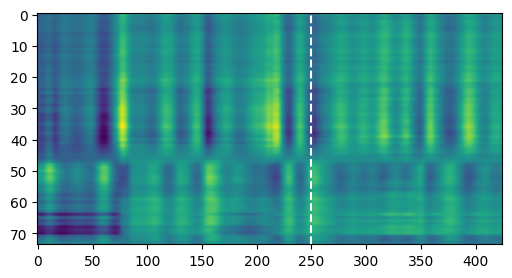

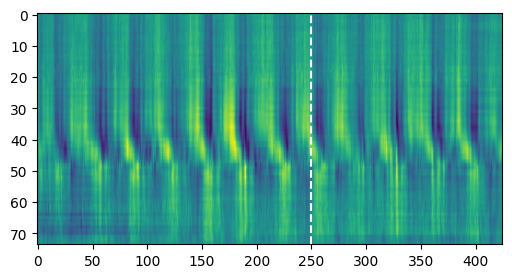

In [61]:
data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/train_recons_a_1.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/test_recons_a_1.npy")
data_recon = np.vstack((data_train, data_test))
print(len(data_train))
print(len(data_test))
plt.figure(figsize = (6,3))
plt.imshow(data_recon[:,:-1].T, aspect = 'auto')
plt.axvline(250, color = 'white', linestyle = '--')
plt.show()


data_train = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/train_gt_a_1.npy")
data_test = np.load("/home/amy/SHRED_neuro/mice/data_output/exp_3/test_gt_a_1.npy")
data_gt= np.vstack((data_train, data_test))
plt.figure(figsize = (6,3))
plt.imshow(data_gt[:,:-1].T, aspect = 'auto')
plt.axvline(250, color = 'white', linestyle = '--')